# Multi-Dimension Scaling 
is a distance-preserving manifold learning method. All manifold learning algorithms assume the dataset lies on a smooth, non linear manifold of low dimension and that a mapping f: $R^{D}$ -> $R^{d}$ (D>>d) can be found by preserving one or more properties of the higher dimension space. Distance preserving methods assume that a manifold can be defined by the pairwise distances of its points. In distance preserving methods, a low dimensional embedding is obtained from the higher dimension in such a way that pairwise distances between the points remain same. Some distance preserving methods preserve spatial distances (MDS) while some preserve graph distances.

MDS is not a single method but a family of methods. MDS takes a dissimilarity matrix $D$ where $D_{ij}$ represents the dissimilarity between points $i$ and $j$ and produces a mapping on a lower dimension, preserving the dissimilarities as closely as possible. The dissimilarity matrix could be observed or calculated from the given dataset.

MDS can be divided into two categories:

- **Metric MDS** - Metric MDS is used for quantitative data and tries to preserve the original dissimilarity metrics. 

- **Non-Metric MDS** - Non-metric MDS is used for ordinal data. It tries to keep the order of dissimialrity metrics intact.

# t-Distributed Stochastic Neighbor Embedding (t-SNE)

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a non-linear technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. It is extensively applied in image processing, NLP, genomic data and speech processing. To keep things simple, here’s a brief overview of working of t-SNE:

- The algorithms starts by calculating the probability of similarity of points in high-dimensional space and calculating the probability of similarity of points in the corresponding low-dimensional space. The similarity of points is calculated as the conditional probability that a point A would choose point B as its neighbor if neighbors were picked in proportion to their probability density under a Gaussian (normal distribution) centered at A.

- It then tries to minimize the difference between these conditional probabilities (or similarities) in higher-dimensional and lower-dimensional space for a perfect representation of data points in lower-dimensional space.

- To measure the minimization of the sum of difference of conditional probability t-SNE minimizes the sum of Kullback-Leibler divergence of overall data points using a gradient descent method.


In simpler terms, t-Distributed stochastic neighbor embedding (t-SNE) minimizes the divergence between two distributions: a distribution that measures pairwise similarities of the input objects and a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding.

In this way, t-SNE maps the multi-dimensional data to a lower dimensional space and attempts to find patterns in the data by identifying observed clusters based on similarity of data points with multiple features. However, after this process, the input features are no longer identifiable, and you cannot make any inference based only on the output of t-SNE. Hence it is mainly a data exploration and visualization technique.

I recommend to familiarize with this amazing blogpost https://distill.pub/2016/misread-tsne/ which graphically shows traps associated with use of t-SNE and how  hyperparameters selection can  affect final embeding.



### To better illustrate properties of individual methods of reducing dimensionality (from this and previous lab), create a set of points in the shape of a roulade.  To do it:

1. Prepare a point generator for the circles in this generator, ensure that the radius decreases with the next steps (in this way you will get a spiral)

2. Treat the spiral as a cross-sectional solid, creating a croissant / crescent roll

3. Move the points in the roll with a slight noise to avoid their perfect placement

4. For better visualization, you can give individual points a color depending, e.g. on the distance from the center of the roulade

5. Generated roulade should resemble the picture below

In [2]:
from time import time
import math
import random
# import mkl
import glob

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from scipy import stats
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image
from matplotlib.cbook import get_sample_data
from matplotlib.offsetbox import TextArea, DrawingArea, OffsetImage, AnnotationBbox
from IPython.display import Image
import tensorflow as tf
from tensorflow import keras

import warnings
warnings.filterwarnings("ignore")

sn.set(color_codes=True)
np.random.seed(1234)
# mkl.set_num_threads(4)
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = [20, 20]



## Roulade points generator

In [7]:
def random_spiral_point(density=2):
    p = random.random() ** 0.5
    return p * math.cos(p * density * np.pi * 2), p * math.sin(p * density * np.pi * 2)


def uniform_spiral(density=3, steps=100):
    x, y = [], []
    for i in range(steps):
        x.append((i / steps) ** 0.5 * math.cos((i / steps) ** 0.5 * density * np.pi * 2))
        y.append((i / steps) ** 0.5 * math.sin((i / steps) ** 0.5 * density * np.pi * 2))

    return x, y


def spiral2roll(xli, yli, width=7, angle=0.1):
    nx, ny, nz, d = [], [], [], []
    for x, y in zip(xli, yli):
        p = random.random()
        nx.append((width + x) * math.cos(angle * p * np.pi * 2))
        ny.append((width + x) * math.sin(angle * p * np.pi * 2))
        nz.append(y)
        d.append((x ** 2 + y ** 2) ** 0.5)
    return nx, ny, nz, d


def uniform_roll(xli, yli, width=7, angle=0.25, density=5, noise_factor=0.05):
    nx, ny, nz, d = [], [], [], []
    d1 = [((x ** 2 + y ** 2) ** 0.5) for x, y in zip(xli, yli)]
    for i in range(density):
        nx.extend(
            [(width + x) * math.cos(angle * i / density * np.pi * 2) + (random.random() - 0.5) * noise_factor for x in
             xli])
        ny.extend(
            [(width + x) * math.sin(angle * i / density * np.pi * 2) + (random.random() - 0.5) * noise_factor for x in
             xli])
        nz.extend(yli)
        d.extend(d1)
    return nx, ny, nz, d


def roll_generator(to_array=True, spiral_density=3, spiral_steps=20, width=7, angle=0.3, density=5):
    x, y = uniform_spiral(density=spiral_density, steps=spiral_steps)
    x, y, z, d = uniform_roll(x, y, width=width, angle=angle, density=density)

    if to_array:
        return np.array([x, y, z]).T, d
    else:
        return x, y, z, d


In [5]:
def plot_roulade(x, y, z, d=None, name='photo.png', display=True):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])
    plt.savefig('data/' + name)
    if display is False:
        plt.close()

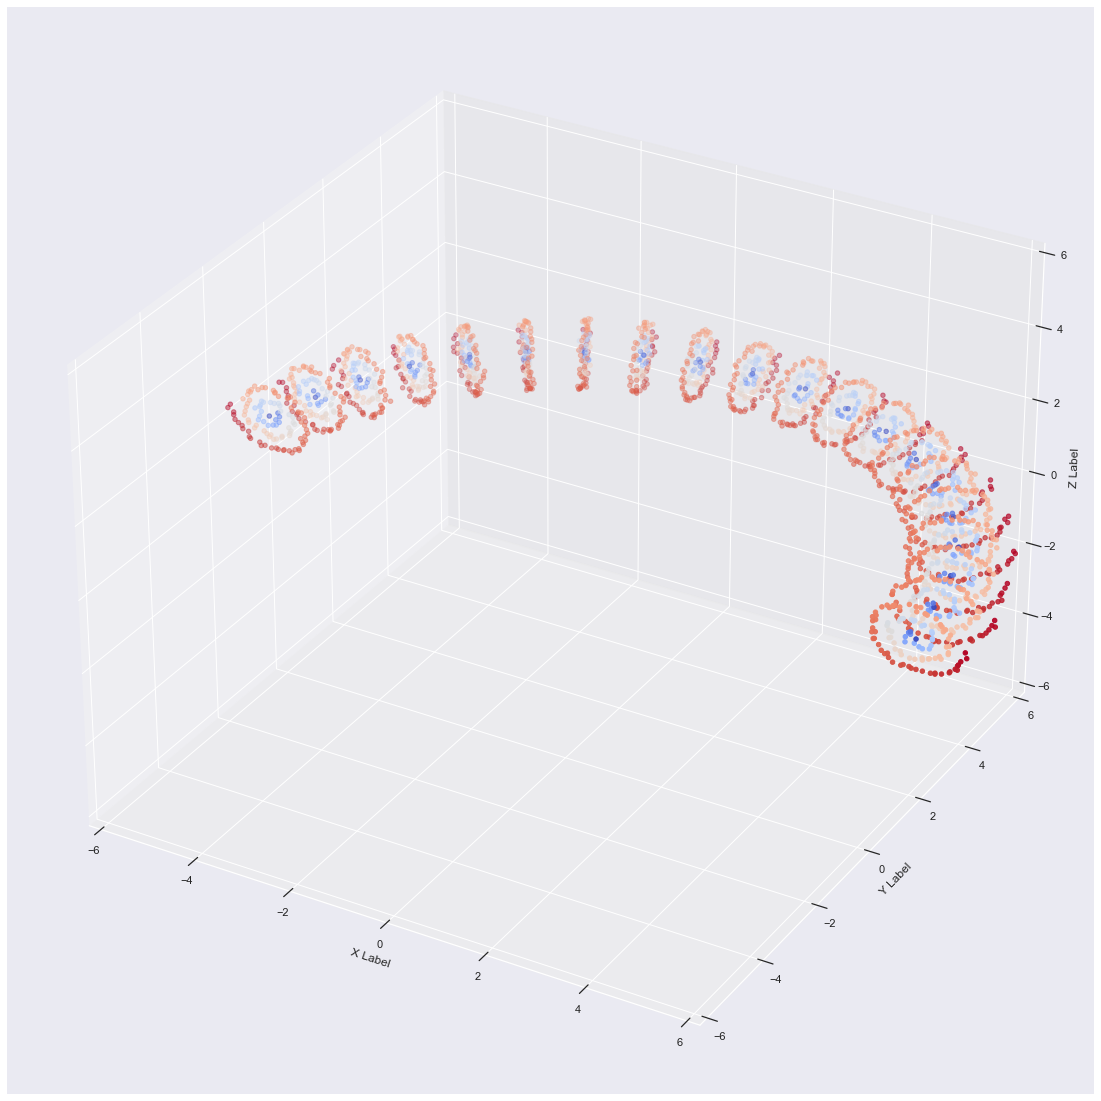

In [8]:
xl, yl = uniform_spiral()
x, y, z, d = uniform_roll(xl, yl, width=7, angle=0.5, density=20, noise_factor=0.15)
plot_roulade(x, y, z, d=d)

#### Visualize the prepared set of points by projecting onto a 2D plane, changing the following aspects in subsequent approaches:

1. Density of points generated, in terms of points per spiral

2. Distance between roll layers, layer density

3. Visualization method: PCA, KernelPCA, MDS, t-SNE

4. generate at least a few plots per method


#### Save each generated chart, you will later need it to embeding images

#### PCA implementation

In [16]:
def show_PCA(spiral_density=3, spiral_steps=20, width=7, angle=0.5, roll_density=5):
    fig = plt.figure()
    x, y, z, d = roll_generator(to_array=False, spiral_density=spiral_density,
                                spiral_steps=spiral_steps, width=width,
                                angle=angle, density=roll_density)
    from mpl_toolkits.mplot3d import Axes3D

    # fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])

    ax2 = fig.add_subplot(122)
    points, d = roll_generator(to_array=True, spiral_density=spiral_density,
                               spiral_steps=spiral_steps, width=width,
                               angle=angle, density=roll_density)

    from sklearn.decomposition import PCA
    embedding = PCA(n_components=2)
    points_transformed = embedding.fit_transform(points)
    points_transformed.shape

    points_transformed_t = points_transformed.T
    points_transformed_t.shape

    ax2.scatter(points_transformed_t[0], points_transformed_t[1], c=d, cmap=plt.cm.coolwarm)
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')

    plt.rcParams["figure.figsize"] = [12, 6]

    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'pca_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png',
                bbox_inches=extent)

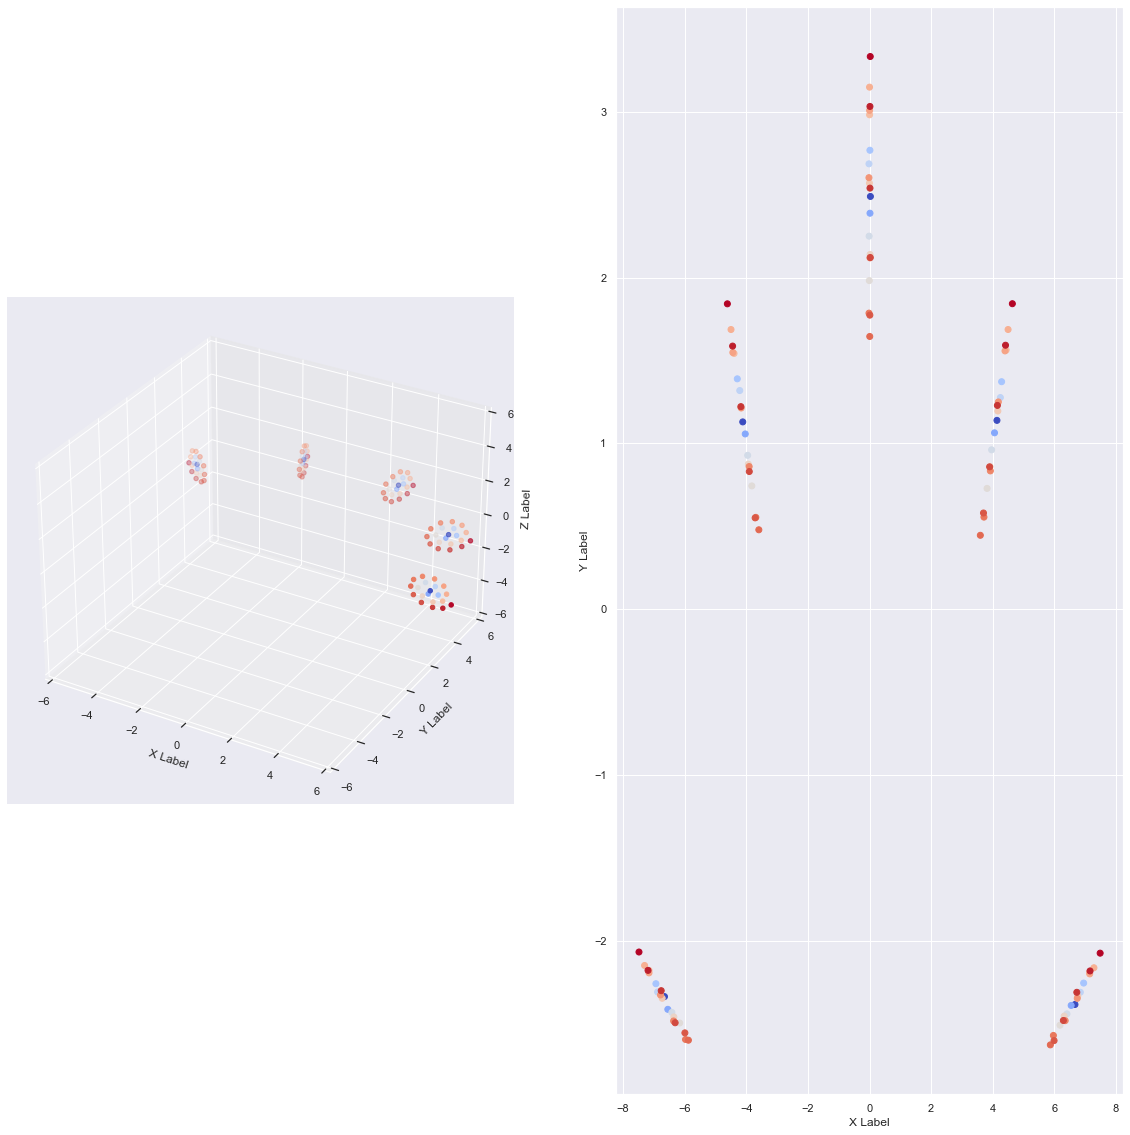

In [17]:
show_PCA()

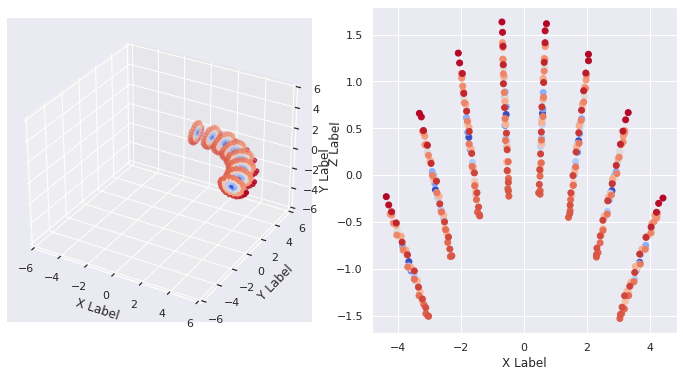

In [ ]:
show_PCA(spiral_density=4, spiral_steps=50, width=5, angle=0.3, roll_density=8)

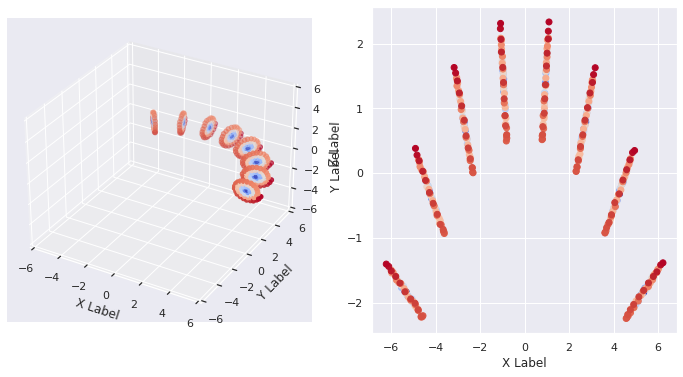

In [ ]:
show_PCA(spiral_density=4, spiral_steps=50, width=6, angle=0.4, roll_density=8)

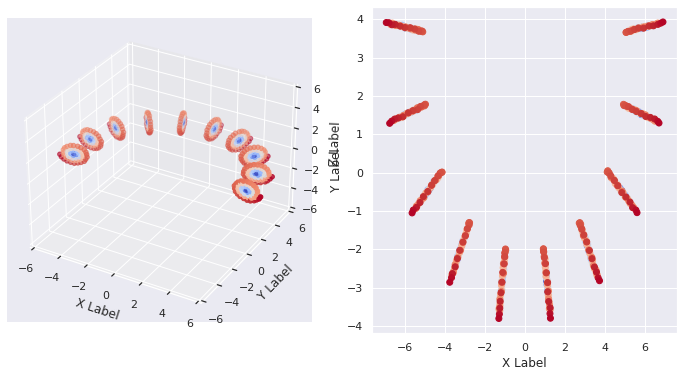

In [ ]:
show_PCA(spiral_density=4, spiral_steps=50, width=6, angle=0.60, roll_density=10)

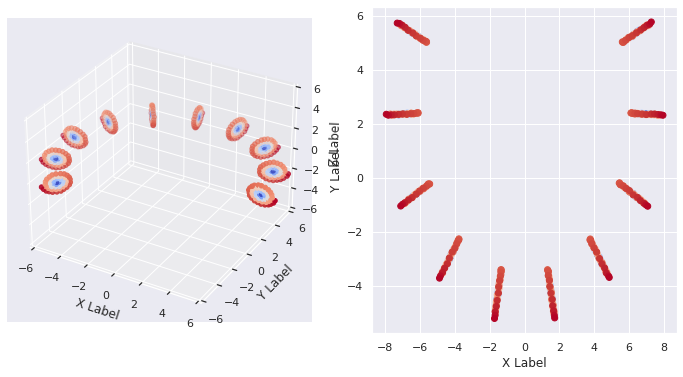

In [ ]:
show_PCA(spiral_density=4, spiral_steps=50, width=7, angle=0.70, roll_density=10)

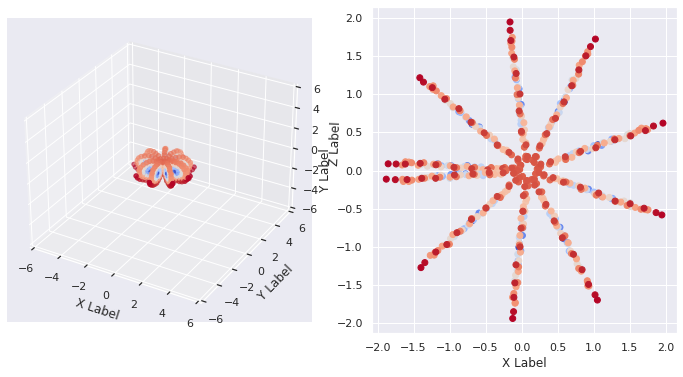

In [ ]:
show_PCA(spiral_density=4, spiral_steps=50, width=1, angle=2.2, roll_density=10)

Patrzac na obrazki wygenrowane przez metode PCA, mozna odniesc wrazenie ze bierze ona pod uwagę tylko punkty w plaszczyznie x oraz y. W żaden sposob nie mamy zobrazowanej zaleznosci miedzy punktami na plaszczyznie z. Widzimy tak jakby rzut z gory.

#### KernelPCA implementation

In [11]:
def show_KernelPCA(spiral_density=3, spiral_steps=20, width=7, angle=0.5, roll_density=5):
    fig = plt.figure()
    x, y, z, d = roll_generator(to_array=False, spiral_density=spiral_density,
                                spiral_steps=spiral_steps, width=width,
                                angle=angle, density=roll_density)
    from mpl_toolkits.mplot3d import Axes3D

    # fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])

    ax2 = fig.add_subplot(122)
    points, d = roll_generator(to_array=True, spiral_density=spiral_density,
                               spiral_steps=spiral_steps, width=width,
                               angle=angle, density=roll_density)

    from sklearn.decomposition import KernelPCA
    embedding = KernelPCA(n_components=2, degree=3, kernel='cosine', n_jobs=-1)
    points_transformed = embedding.fit_transform(points)
    points_transformed.shape

    points_transformed_t = points_transformed.T
    points_transformed_t.shape

    ax2.scatter(points_transformed_t[0], points_transformed_t[1], c=d, cmap=plt.cm.coolwarm)
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')

    plt.rcParams["figure.figsize"] = [12, 6]

    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'kpca_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png',
                bbox_inches=extent)

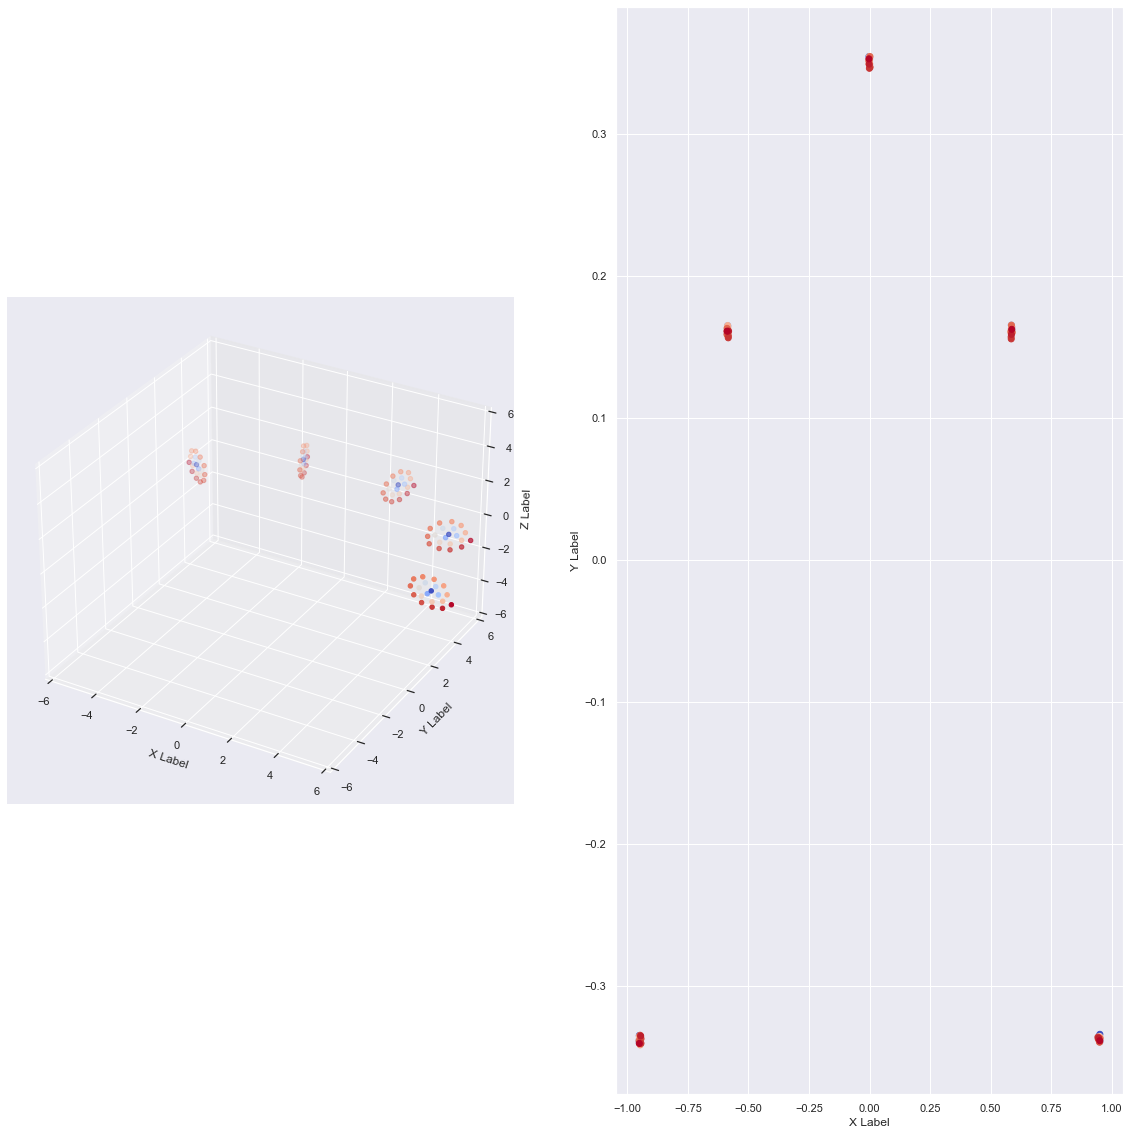

In [10]:
show_KernelPCA()

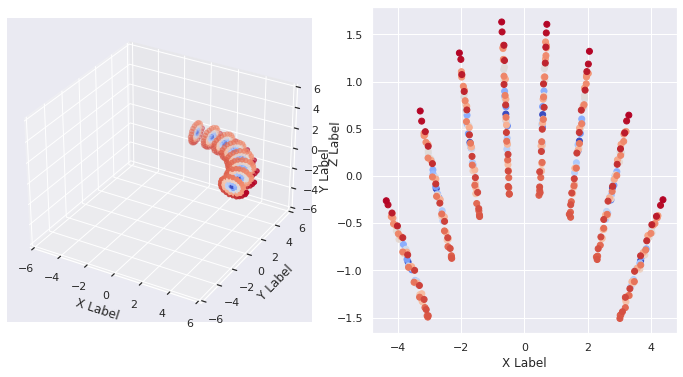

In [ ]:
show_KernelPCA(spiral_density=4, spiral_steps=50, width=5, angle=0.3, roll_density=8)

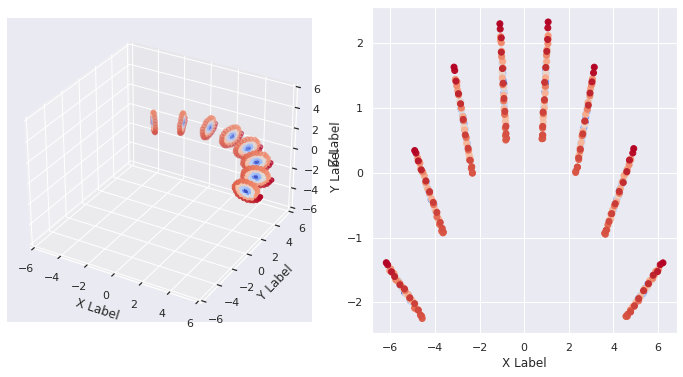

In [ ]:
show_KernelPCA(spiral_density=4, spiral_steps=50, width=6, angle=0.4, roll_density=8)

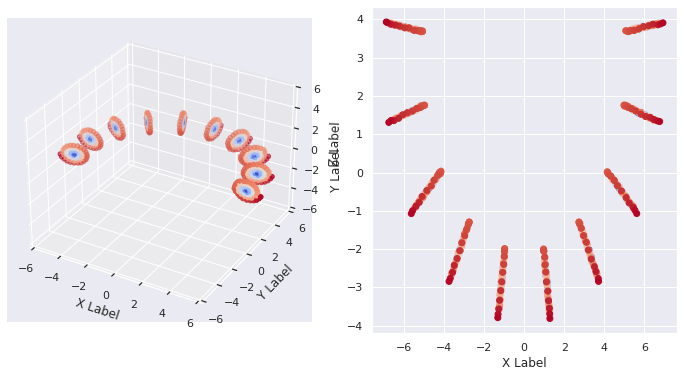

In [ ]:
show_KernelPCA(spiral_density=4, spiral_steps=50, width=6, angle=0.60, roll_density=10)

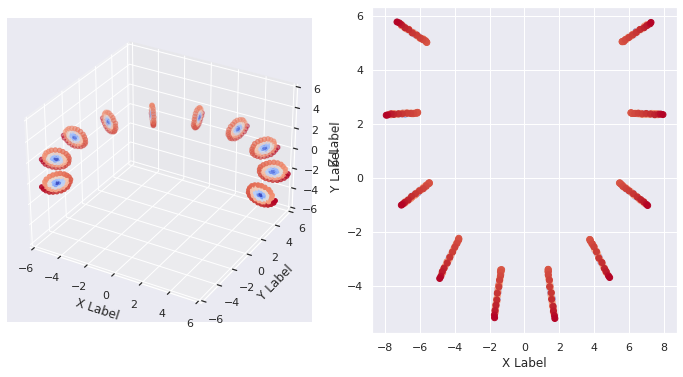

In [ ]:
show_KernelPCA(spiral_density=4, spiral_steps=50, width=7, angle=0.70, roll_density=10)

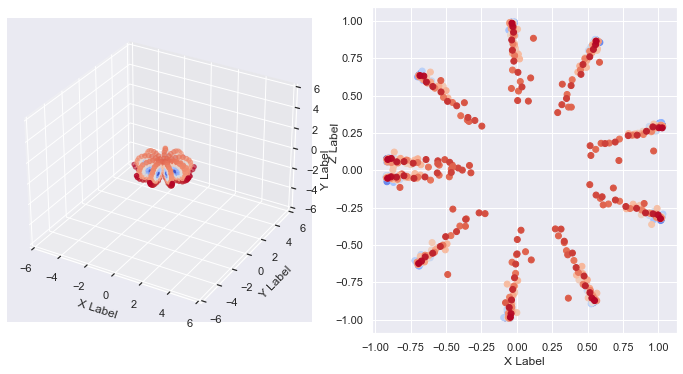

In [12]:
show_KernelPCA(spiral_density=4, spiral_steps=50, width=1, angle=2.2, roll_density=10)

KernelPCA nie daje poprawy w stosunku do PCA, dla domyśnych parametrów. Zmiania parametrów nie jest pomocna - nadal nie widzimy odseparowanych niebieskich punktów

#### MDE implementation

In [18]:
def show_MDE(spiral_density=3, spiral_steps=20, width=7, angle=0.5, roll_density=5):
    fig = plt.figure()
    x, y, z, d = roll_generator(to_array=False, spiral_density=spiral_density,
                                spiral_steps=spiral_steps, width=width,
                                angle=angle, density=roll_density)
    from mpl_toolkits.mplot3d import Axes3D

    # fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])

    ax2 = fig.add_subplot(122)
    points, d = roll_generator(to_array=True, spiral_density=spiral_density,
                               spiral_steps=spiral_steps, width=width,
                               angle=angle, density=roll_density)

    from sklearn.manifold import MDS
    embedding = MDS(n_components=2)
    points_transformed = embedding.fit_transform(points)
    points_transformed.shape

    points_transformed_t = points_transformed.T
    points_transformed_t.shape

    ax2.scatter(points_transformed_t[0], points_transformed_t[1], c=d, cmap=plt.cm.coolwarm)
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')

    plt.rcParams["figure.figsize"] = [12, 6]

    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(f'mde_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png',
                bbox_inches=extent)

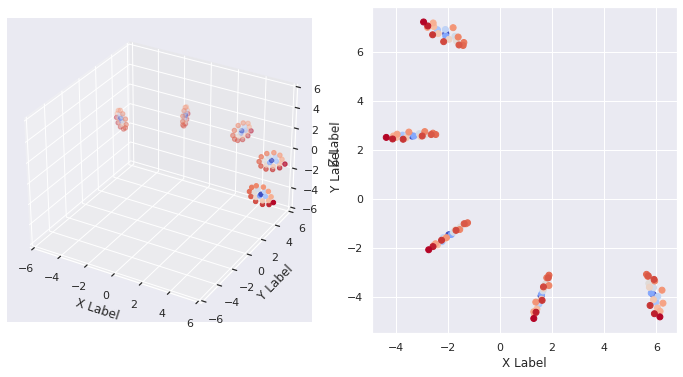

In [ ]:
show_MDE()

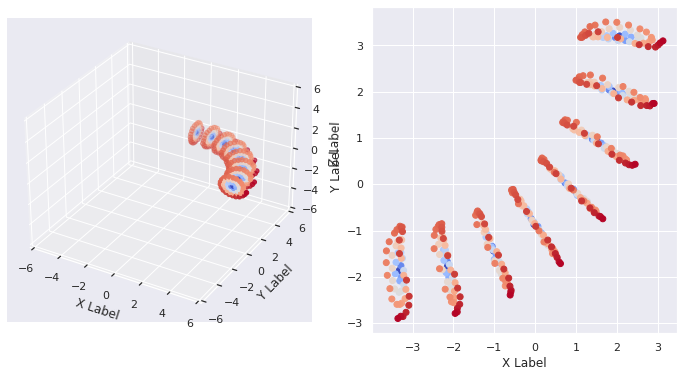

In [ ]:
show_MDE(spiral_density=4, spiral_steps=50, width=5, angle=0.3, roll_density=8)

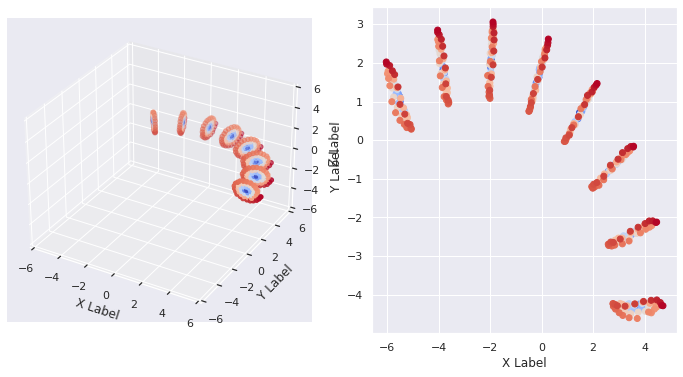

In [ ]:
show_MDE(spiral_density=4, spiral_steps=50, width=6, angle=0.4, roll_density=8)

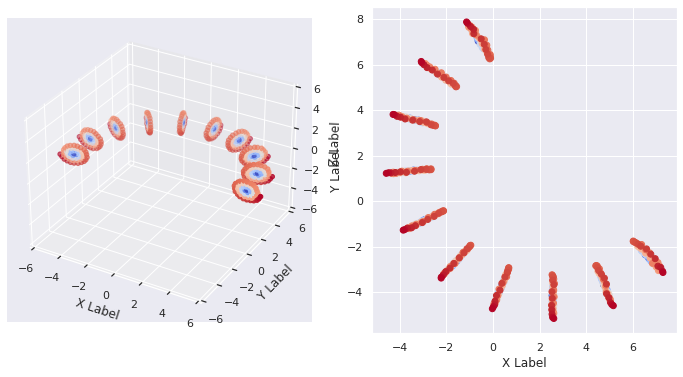

In [ ]:
show_MDE(spiral_density=4, spiral_steps=50, width=6, angle=0.60, roll_density=10)

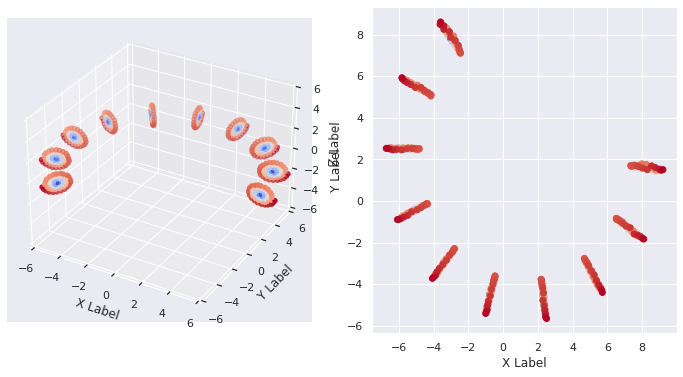

In [ ]:
show_MDE(spiral_density=4, spiral_steps=50, width=7, angle=0.70, roll_density=10)

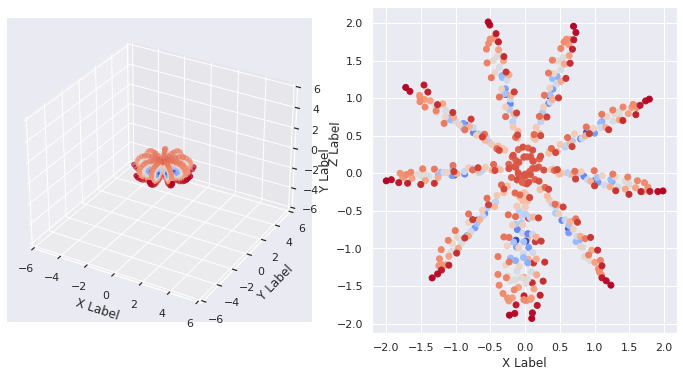

In [ ]:
show_MDE(spiral_density=4, spiral_steps=50, width=1, angle=2.2, roll_density=10)

#### t-SNE implementation

In [ ]:
def show_tSNE(spiral_density=3, spiral_steps=20, width=7, angle=0.5, roll_density=5, n_neighbors=5,
              metric='euclidean', perplexity=30):
    fig = plt.figure()
    x, y, z, d = roll_generator(to_array=False, spiral_density=spiral_density,
                                spiral_steps=spiral_steps, width=width,
                                angle=angle, density=roll_density)
    from mpl_toolkits.mplot3d import Axes3D

    # fig = plt.figure()
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x, y, z, c=d, cmap=plt.cm.coolwarm)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    ax.set_xlim([-6, 6])
    ax.set_ylim([-6, 6])
    ax.set_zlim([-6, 6])

    ax2 = fig.add_subplot(122)
    points, d = roll_generator(to_array=True, spiral_density=spiral_density,
                               spiral_steps=spiral_steps, width=width,
                               angle=angle, density=roll_density)

    from sklearn.manifold import TSNE
    points_transformed = TSNE(n_components=2, metric=metric, perplexity=perplexity).fit_transform(points)

    points_transformed_t = points_transformed.T

    ax2.scatter(points_transformed_t[0], points_transformed_t[1], c=d, cmap=plt.cm.coolwarm)
    ax2.set_xlabel('X Label')
    ax2.set_ylabel('Y Label')

    plt.rcParams["figure.figsize"] = [12, 6]

    extent = ax2.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    fig.savefig(
        f'tsne_n{n_neighbors}_spst{spiral_steps}_roldens{roll_density}_w{width}_a{angle}_sd{spiral_density}.png',
        bbox_inches=extent)
    return points

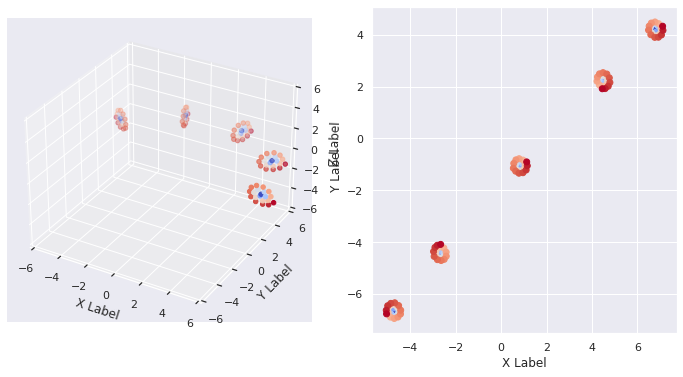

In [ ]:
points = show_tSNE()

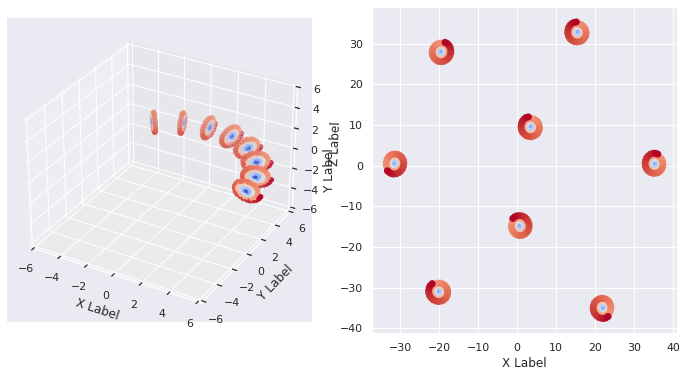

In [ ]:
show_tSNE(spiral_density=4, spiral_steps=50, width=6, angle=0.4, roll_density=8, n_neighbors=4, perplexity=30)

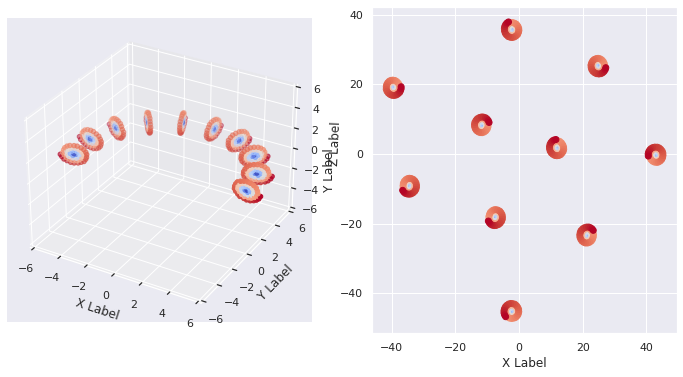

In [ ]:
show_tSNE(spiral_density=4, spiral_steps=50, width=6, angle=0.60, roll_density=10)

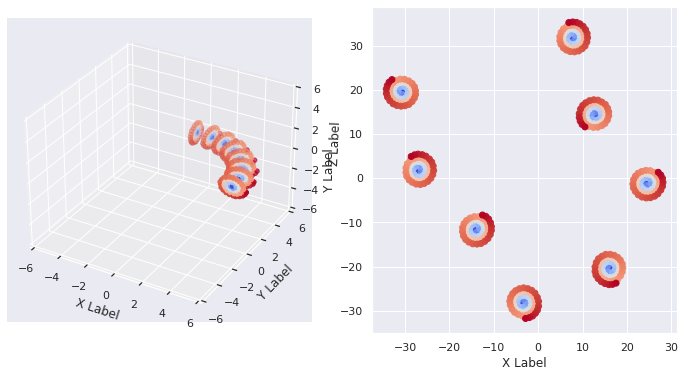

In [ ]:
show_tSNE(spiral_density=4, spiral_steps=50, width=5, angle=0.3, roll_density=8)

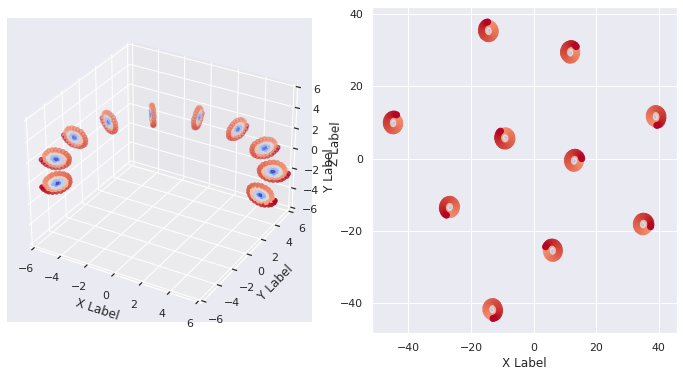

In [ ]:
show_tSNE(spiral_density=4, spiral_steps=50, width=7, angle=0.70, roll_density=10)

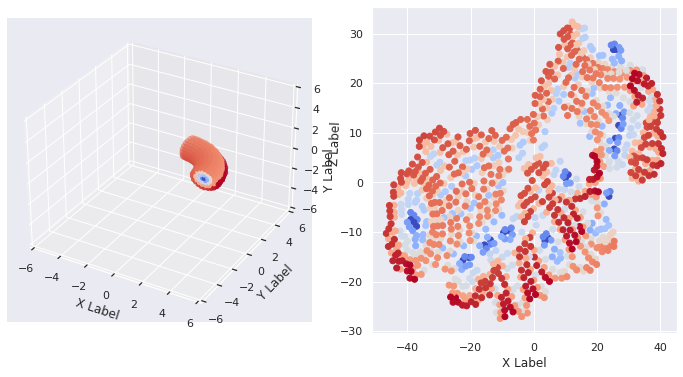

In [ ]:
show_tSNE(spiral_density=4, spiral_steps=50, width=3, angle=0.25, roll_density=20)

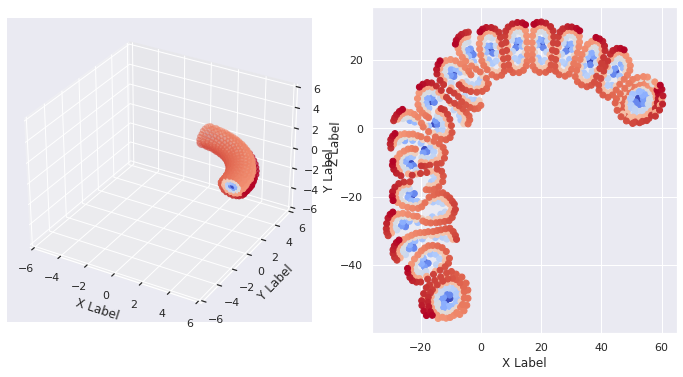

In [ ]:
show_tSNE(spiral_density=4, spiral_steps=50, width=5, angle=0.25, roll_density=20)

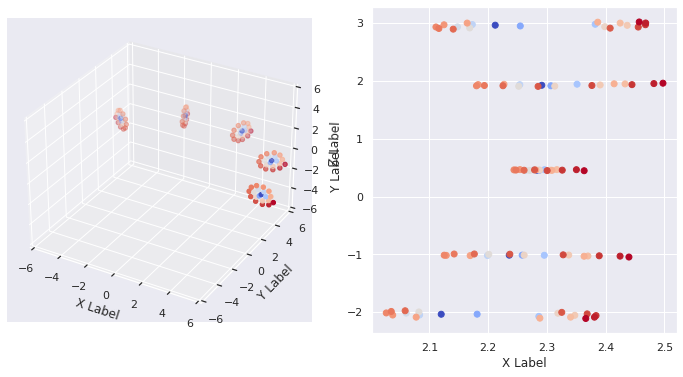

In [ ]:
show_tSNE(spiral_density=3, spiral_steps=20, width=7, angle=0.5, roll_density=5, n_neighbors=5, perplexity=60)

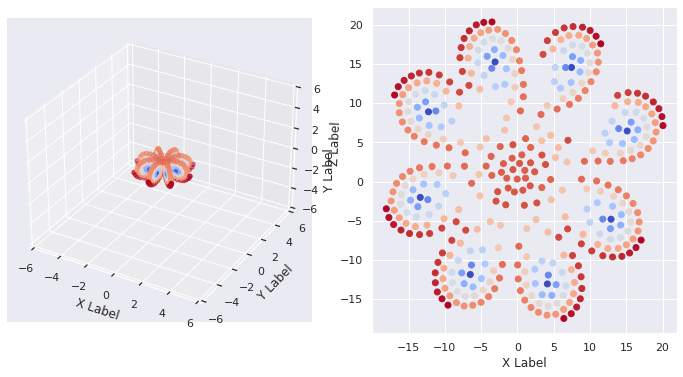

In [ ]:
show_tSNE(spiral_density=4, spiral_steps=50, width=1, angle=1, roll_density=8, n_neighbors=3, perplexity=40)

### In this way, you should get a set of images showing the various available projections of the original roulade to the 2D plane. Treat these images as elements of a new data set, we treat image pixels as a high-dimensional vector. Use t-SNE to project the newly created set of 2d projection thumbnails into a 2-dimensional space.

In [ ]:
import sklearn
print(sklearn.neighbors.VALID_METRICS['brute'])

show_tSNE(spiral_density=3, spiral_steps = 20, width=7, angle=0.5, roll_density=5, n_neighbors=5,metric='cosine', perplexity=30)

In [23]:
from PIL import Image
import glob

In [24]:
def read_images(flat=True):
    images = []
    for filename in glob.glob('data/*.png'):
        img=Image.open(filename)
        img_as_arr = np.asarray(img)
        if flat is True:
            img_as_arr = img_as_arr.flatten()
        images.append(img_as_arr)
    return np.asarray(images)

images = read_images(False)
flatten_images = read_images()

In [ ]:
def execute_tsne(images):
    from sklearn.manifold import TSNE
    points_transformed = TSNE(n_components=2, metric='euclidean', perplexity=30).fit_transform(images)
    return points_transformed

In [ ]:
tsne_result = execute_tsne(flatten_images)

In [ ]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(25,25), image_zoom=0.25):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

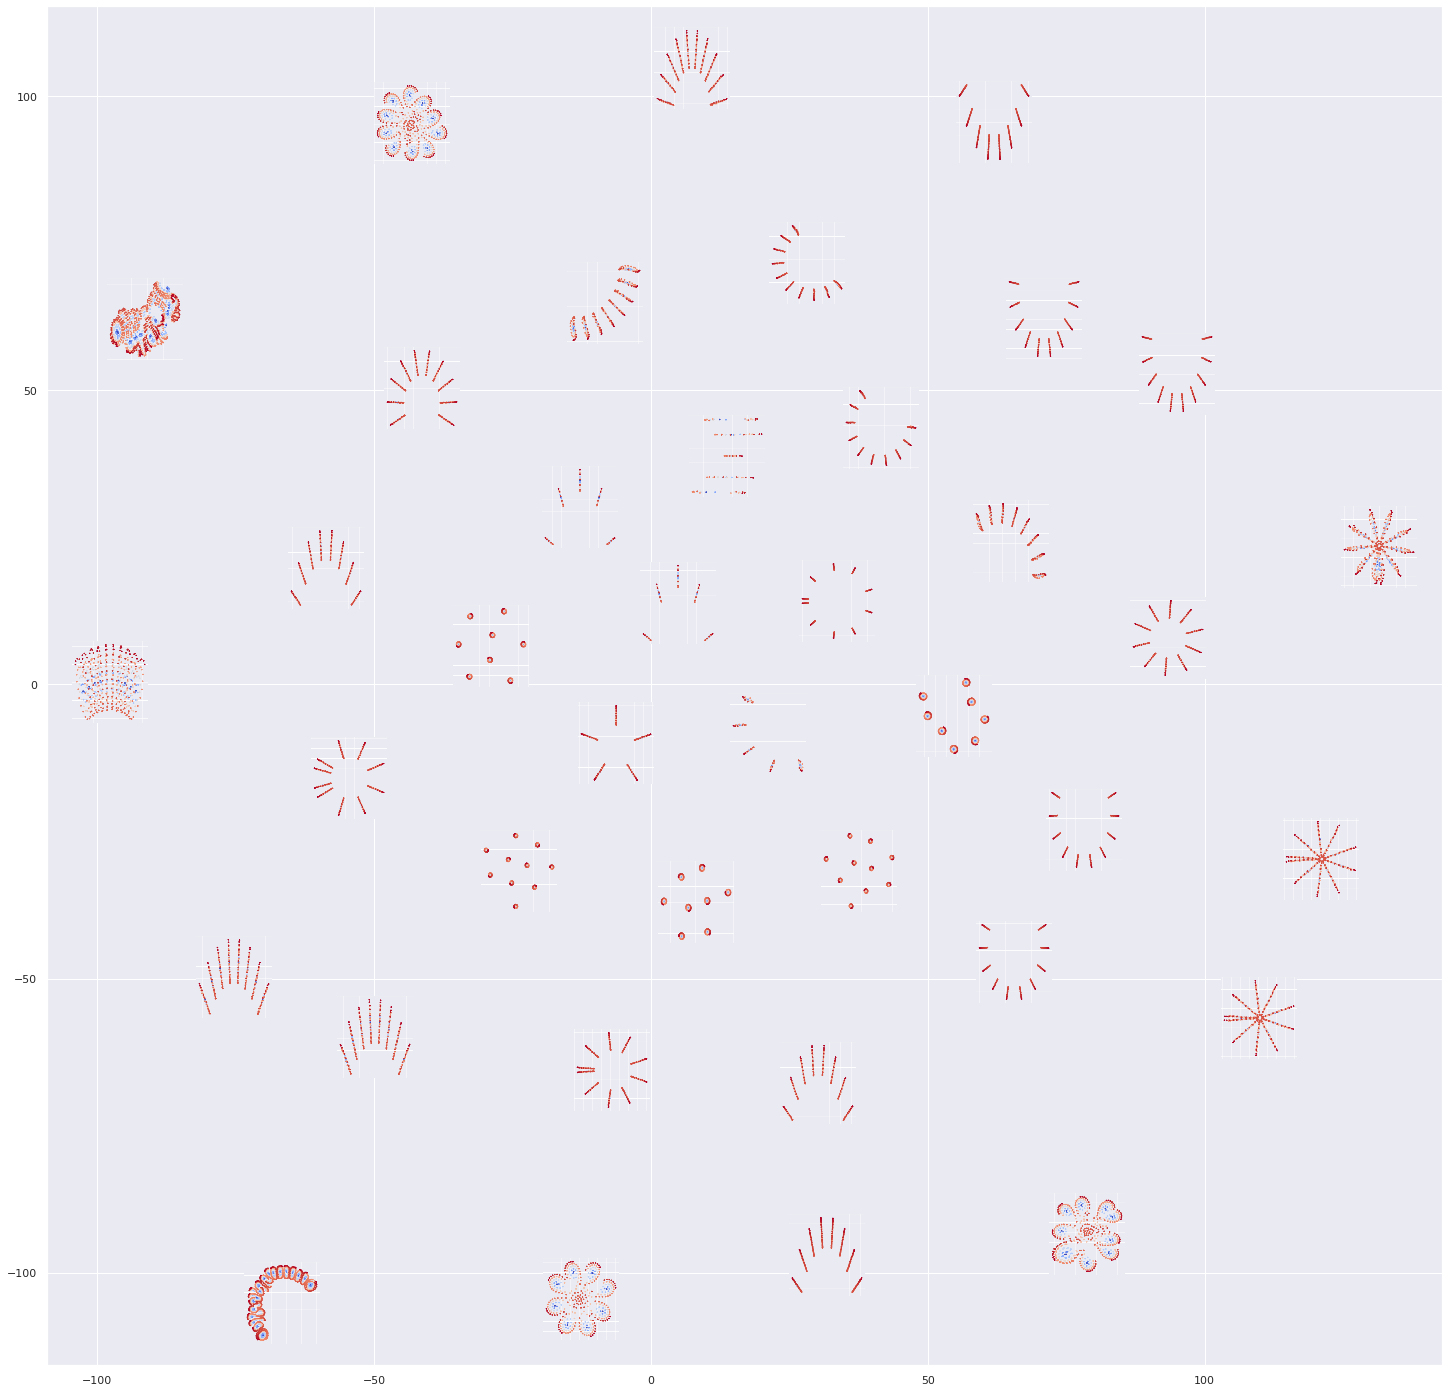

In [ ]:
visualize_scatter_with_images(tsne_result, images)

# homework - work with more complex data (higher dimensionality).

- use a basic machine learning set representing black and white scans of 32x32 pixel handwritten digits (MNIST)
- apply dimensionality reduction on these data using PCA, MDS and t-SNE methods
- Plot results
- Pick first 1000-2000 points as TSNE takes a lot of time for all samples


In [13]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
print(x_train.shape)
print(y_train.shape)


(60000, 28, 28)
(60000,)


In [14]:
def plot_2d_mnist(X, y):
    fig, plot = plt.subplots()
    # fig.set_size_inches(16, 16)
    plt.prism()

    for i in range(10):
        digit_indices = (y == i)
        dim1 = X[digit_indices][:, 0]
        dim2 = X[digit_indices][:, 1]
        plot.scatter(dim1, dim2)

    plot.set_xticks(())
    plot.set_yticks(())

    plt.tight_layout()
    plt.legend(labels = [i for i in range(10)])
    plt.show()

In [33]:
# narrow down sample size
n_samples = 1500

y_train_small = y_train[:n_samples]
x_train_small = x_train[:n_samples]



(1500, 784)

In [35]:
np.unique(y_train_small, return_counts=True) # sprawdzenie czy podzbiór ma rozład jednorodny cech

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([140, 172, 144, 142, 160, 137, 141, 177, 134, 153]))

In [64]:
#PCA 
def mnist_PCA(x):
    from sklearn.decomposition import PCA
    embedding = PCA(n_components=2)
    x_transformed = embedding.fit_transform(x)
    print(x_transformed.shape)
    return(x_transformed)

In [61]:
print(x_train_small.shape)
x_train_small_2d = x_train_small.reshape(-1, 28 * 28)
print(x_train_small_2d.shape)


(1500, 28, 28)
(1500, 784)


(1500, 2)


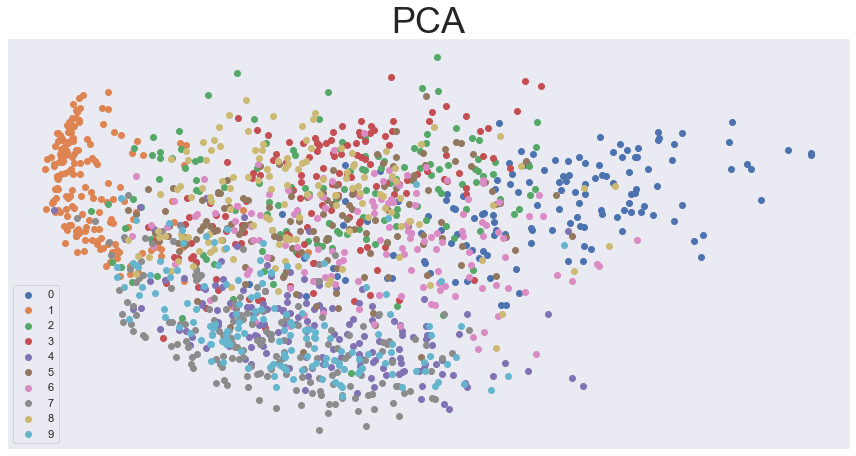

In [66]:

transformed_x = mnist_PCA(x_train_small_2d)
plot_2d_mnist(transformed_x, y_train_small)

In [78]:
#MDS
def mnist_MDE(x_train):
    from sklearn.manifold import MDS
    embedding = MDS(n_components=2)
    points_transformed = embedding.fit_transform(x_train)
    return points_transformed

transformed_x_MDE = mnist_MDE(x_train_small_2d)

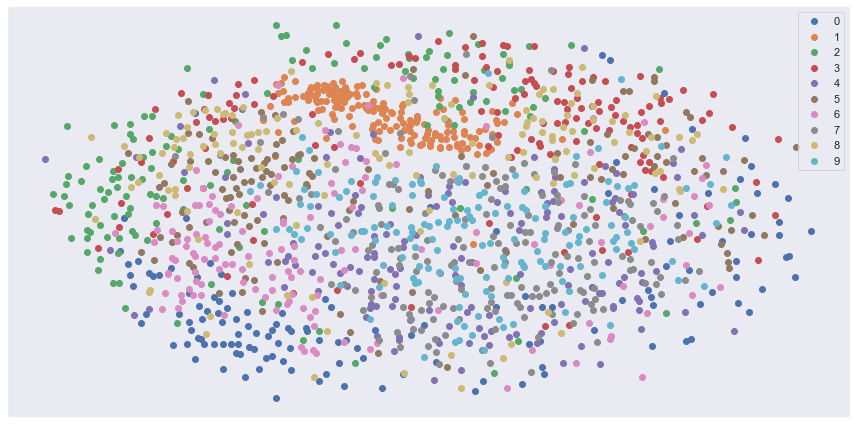

In [79]:
plot_2d_mnist(transformed_x_MDE, y_train_small)

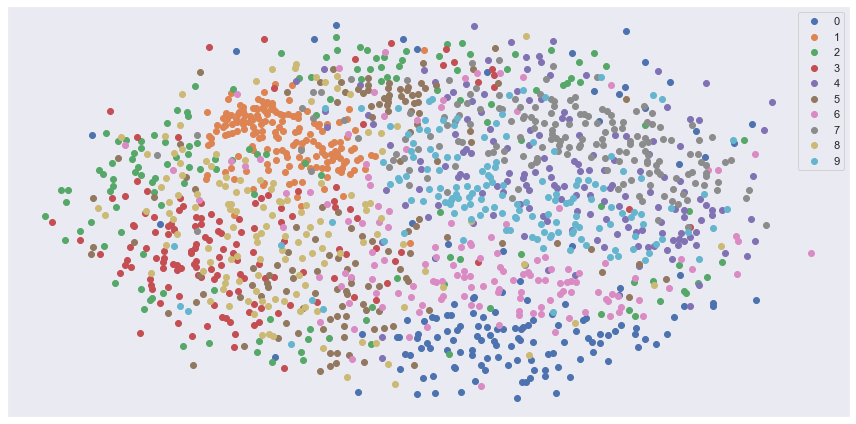

In [80]:
def mnist_MDE(x_train):
    from sklearn.manifold import MDS
    embedding = MDS(n_components=2, max_iter=400, verbose=1, n_jobs=-1)
    points_transformed = embedding.fit_transform(x_train)
    return points_transformed

transformed_x_MDE = mnist_MDE(x_train_small_2d)
plot_2d_mnist(transformed_x_MDE, y_train_small)

In [ ]:
transformed_x_MDE = mnist_MDE(x_train.reshape(-1, 28 * 28))
plot_2d_mnist(transformed_x_MDE, y_train)

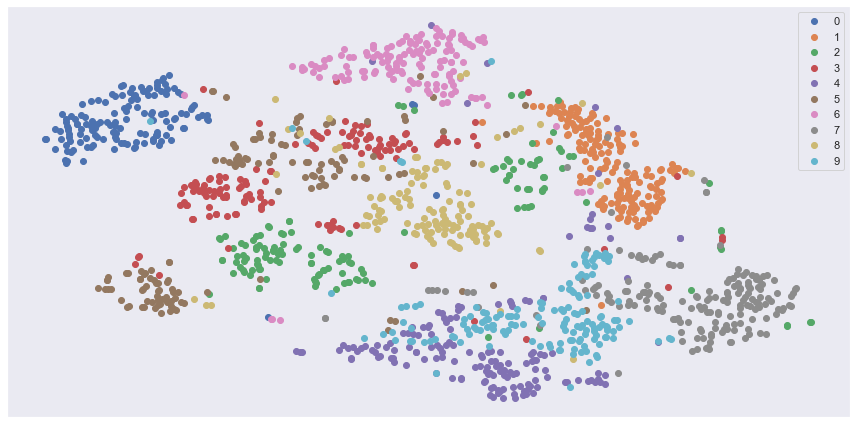

In [85]:
# t-SNE
def tsne_mnist(x_train, perplexity=30):
    from sklearn.manifold import TSNE
    points_transformed = TSNE(n_components=2, metric='euclidean', perplexity=perplexity).fit_transform(x_train)
    return points_transformed
tsne_x_train = tsne_mnist(x_train_small_2d)
plot_2d_mnist(tsne_x_train, y_train_small)

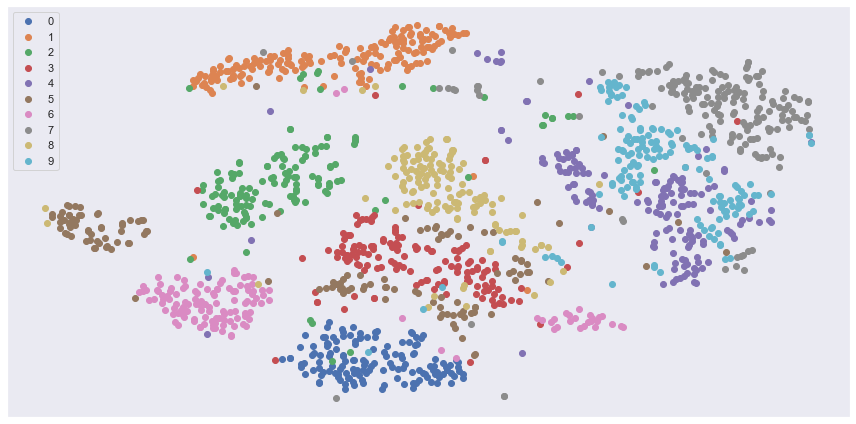

In [88]:
def tsne_mnist(x_train, perplexity=30):
    from sklearn.manifold import TSNE
    points_transformed = TSNE(n_components=2, metric='cosine', perplexity=perplexity).fit_transform(x_train)
    return points_transformed
tsne_x_train = tsne_mnist(x_train_small_2d)
plot_2d_mnist(tsne_x_train, y_train_small)

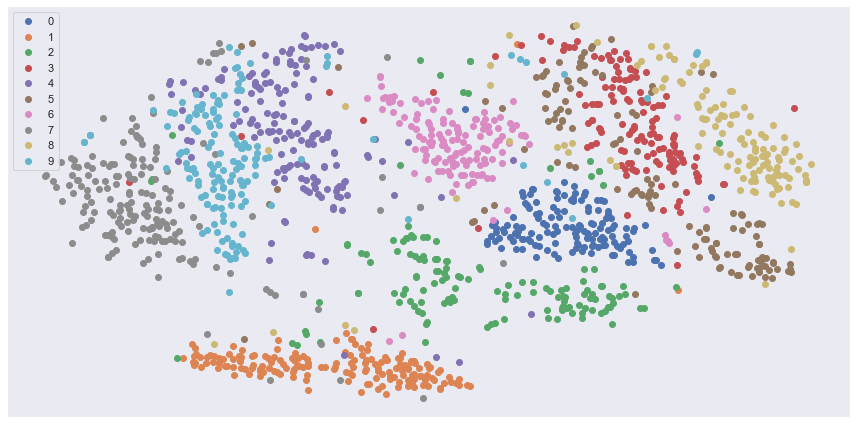

In [92]:
def tsne_mnist(x_train, perplexity=100):
    from sklearn.manifold import TSNE
    points_transformed = TSNE(n_components=2, metric='cosine', perplexity=perplexity).fit_transform(x_train)
    return points_transformed
tsne_x_train = tsne_mnist(x_train_small_2d)
plot_2d_mnist(tsne_x_train, y_train_small)

Najlepiej wypadała metoda tSNE, widzimy wyraźną klasteryzajcę, odpowiednio dobrane parametry mogą jeszcze dalej nieznacznie poprawić jakość danych. Metody PCA i MDE wypałdy znacznie gorzej - wielie liczb jest rozproszonych  niemal po całym wykresie -dobrze klasteryzują liczbę 1.
W przypadku MDE nie widać poprawy przy manipulacji parametrami. W PCA nie za bardzo jest czym manipulować, na pewno w porównaniu do MDE lepiej radzi sobie z klateryzajcą 0. 
